In this script we measure over a large frequency range which we split up in smaller intervals, after each interval we check if the image has moved and if so we correct the position of the laser focus

In [1]:
print 'ready'

ready


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import argrelmax
from os import listdir
from os.path import isfile, join
%matplotlib inline
import threading

import json

# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')

import hardware_modules.ZiControl as zi
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as track
from  hardware_modules.GalvoMirrors import SetGalvoPoint
# from  hardware_modules.PhotodiodeInput import ReadPhotodiode
import hardware_modules.PhotodiodeInput as PDIn



from time import localtime, strftime
import time
# file = './2015-05-21_20-32-29-5.8e-4Torr_NoPinhole_R100k.csv'
# folder = './'


timePerPt = 0.001

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Beam_2_LookingForResonances'

tag = 'Si3Ni4'

# definitions

In [3]:
# =============================================
# =============================================
# take image
# =============================================

def take_image(roi):
    xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.rio_to_galvoparameter(roi)

    scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)

    image_data = scanner.scan()
    return image_data




# =============================================
# =============================================
# show image of full scan
# =============================================

def show_image_all(image_data, roi_initial, roi):
    fig_overwiew = plt.figure()
    ax = plt.subplot(1,1,1)

    xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.rio_to_galvoparameter(roi_initial)
    X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

    p = plt.pcolor(X, Y, image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)
    plt.xlim([xVmin, xVmax])
    plt.ylim([yVmin, yVmax])

    # plt.axes().set_aspect('equal')

    plt.axes().set_aspect(abs((xVmax-xVmin) / (yVmax-yVmin)))
    # print abs((xVmax-xVmin) / (yVmax-yVmin))
    # ---------------------------------------------
    # draw RoI
    track.plot_region(plt, roi, color = 'w')

    #  plot close up
    fig_roi = plt.figure()
    ax = plt.subplot(1,1,1)
    p = plt.pcolor(X, Y, image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    # plt.colorbar()
    p.set_clim(clim_min, clim_max)

    roi_xVmin, roi_xVmax, roi_xPts, roi_yVmin, roi_yVmax, roi_yPts = track.rio_to_galvoparameter(roi)

    plt.xlim([roi_xVmin, roi_xVmax])
    plt.ylim([roi_yVmin, roi_yVmax])
    plt.axes().set_xticks([roi_xVmin, roi_xVmax])
    plt.axes().set_yticks([roi_yVmin, roi_yVmax])

    plt.axes().set_aspect(roi_yPts / roi_xPts)
    plt.plot(roi['xo'], roi['yo'], 'x' , ms = 20)
    
    return fig_overwiew
    
# =============================================
# =============================================
# plot roi and set laser beam to center of region of interest
# =============================================
def plot_roi_and_set_laser(roi, roi_image_data, laser_position, filename = None, counter = None):

    roi.update(laser_position)
    
    fig_roi = plt.figure()
    
    roi_xVmin, roi_xVmax, roi_xPts, roi_yVmin, roi_yVmax, roi_yPts = track.rio_to_galvoparameter(roi)
    X, Y = np.meshgrid( np.linspace(roi_xVmin, roi_xVmax, roi_xPts),  np.linspace(roi_yVmin, roi_yVmax, roi_yPts))

    p = plt.pcolor(X, Y, roi_image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    # p.set_clim(clim_min, clim_max)

    plt.xlim([roi_xVmin, roi_xVmax])
    plt.ylim([roi_yVmin, roi_yVmax])

    plt.axes().set_aspect(roi_yPts / roi_xPts)
    plt.plot(roi['xo'], roi['yo'], 'kx' , ms = 20, mew = 1)
    plt.plot(roi['x_laser'], roi['y_laser'], 'wo' , ms = 10, mew = 0.5)
    # plt.plot(roi['xo'], roi['yo'], 'circ' , ms = 20, mew = 2)
    plt.axes().set_xticks([roi_xVmin, roi['xo'], roi_xVmax])
    plt.axes().set_yticks([roi_yVmin, roi['yo'], roi_yVmax])
    
    if filename!= None:
        # optional save RoI image and data
        fig_roi.savefig('{:s}/{:s}_{:03d}_RoI.png'.format(dirpath, filename, counter))
        np.savetxt('{:s}/{:s}_{:03d}_RoI.csv'.format(dirpath, filename, counter), roi_image_data, fmt='%.18e', delimiter=',')

        with open('{:s}/{:s}_{:03d}_RoI.roi'.format(dirpath, filename, counter), 'w') as outfile:
             json.dump(roi, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


    SetGalvoPoint(roi['x_laser'], roi['y_laser']) 
    
    return fig_roi
    
# ======================================================================
# measure mechanical resonance =========================================
# ======================================================================
def measure_mechanical_resonance(roi, roi_image_data, x_offsets, y_offsets, filename):
    
    with open('{:s}/{:s}.zi'.format(dirpath, filename), 'w') as outfile:
        json.dump(zi_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

    zi_hf2 = zi.ZIHF2(zi_parameter['amplitude'],
                      zi_parameter['offset'],
                      zi_parameter['freq'],
                      zi_parameter['ACCoupling'],
                      zi_parameter['inChannel'],
                      zi_parameter['outChannel'],
                      zi_parameter['auxChannel'],
                      zi_parameter['add'],
                      zi_parameter['range']
                     )


    interval_freqStart = freqStart
    
    counter = 0
    interval_counter = 0
    
    while interval_freqStart < freqEnd:
        
        for x_offset in x_offsets:
            for y_offset in y_offsets:
                
                
                # ========================================================================================
                # define new interval for sweep 
                interval_freqStart =  freqStart + interval_counter * interval_sampleNum * freq_df
                interval_freqEnd  =  freqStart + ((interval_counter+1) * interval_sampleNum-1) * freq_df
                sweep_parameter = {
                    'freqStart' : interval_freqStart,
                    'freqEnd' : interval_freqEnd,
                    'sampleNum' : interval_sampleNum,
                    'samplesPerPt' : 4, 
                    'xScale' : 0,
                    'direction' : 0,
                    'loopcount': 1,
                    'timeout' : 1e8
                }

                with open('{:s}/{:s}_sweep_{:03d}.sweep'.format(dirpath, filename, counter), 'w') as outfile:
                    json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

                print '{:s}\t sweeping\t {:03.3f} - {:03.3f}kHz'.format(
                        strftime("%Y-%m-%d %H:%M:%S", localtime()),
                        sweep_parameter['freqStart'] * 1e-3,
                        sweep_parameter['freqEnd']* 1e-3)
                
                print 'counter {:d}, {:0.3f} {:0.3f}'.format(counter, x_offset, y_offset)

                # ========================================================================================
                # measure RoI
                roi_image_data_new = take_image(roi)

                # ========================================================================================
                # compare to previous image and determine new RoI
                roi = track.find_beam_position(roi_image_data, roi_image_data_new, roi)

                # ========================================================================================
                # overwrite data for next iteration
                roi_image_data = roi_image_data_new

                # ========================================================================================
                # plot and set laser position and save RoI image
                laser_position = {"x_laser": roi['xo']+ x_offset, 'y_laser':  roi['yo']+y_offset}

                fig_roi = plot_roi_and_set_laser(roi, roi_image_data, laser_position, filename, counter)

                plt.close(fig_roi)

                print '\t current laser position:\t  {:0.3f}\t {:0.3f}'.format(laser_position['x_laser'], laser_position['y_laser'])
                print '\t current RoI position:\t  {:0.3f}\t {:0.3f}'.format(laser_position['xo'], laser_position['yo'])

                # ========================================================================================
                # look for mechanical resonance and save sweep data

                zi_hf2.sweep(sweep_parameter['freqStart'],
                             sweep_parameter['freqEnd'],
                             sweep_parameter['sampleNum'],
                             sweep_parameter['samplesPerPt'],
                             sweep_parameter['xScale'],
                             sweep_parameter['direction'],
                             sweep_parameter['loopcount'],
                             sweep_parameter['timeout']
                            )



                zi_hf2.writeData('{:s}/{:s}_{:03d}_RoI.dat'.format(dirpath, filename, counter))



        
                counter +=1
        interval_counter += 1

        
        
# ======================================================================
# find_special_x_pos_in_roi =========================================
# ======================================================================
def find_special_x_pos_in_roi():
    '''
        find the x position where the signal is max (positive and negative) and where the slope is highest
    '''
    
    roi_xVmin, roi_xVmax, roi_xPts, roi_yVmin, roi_yVmax, roi_yPts = track.rio_to_galvoparameter(roi)
    x = np.linspace(roi_xVmin,roi_xVmax,roi_xPts)
    img_avg_along_y = np.mean(roi_image_data,0)
    i_min = np.argmin(img_avg_along_y)
    i_max = np.argmax(img_avg_along_y)
    i_0 = np.round(i_min + (i_max- i_min) /2) # np.argmax(np.diff(img_avg_along_y))


    img_xcut = roi_image_data[roi_image_data.shape[0]/2,:]


    plt.plot(x, img_avg_along_y, label = 'int along y')
    plt.plot(x, img_xcut, label = 'cross cut')

    plt.plot(x[i_min], img_avg_along_y[i_min], 'ro')
    plt.plot(x[i_max], img_avg_along_y[i_max], 'ro')
    plt.plot(x[i_0], img_avg_along_y[i_0], 'ro')

    plt.title('xo = {:0.3f}'.format(x[i_min]))
    plt.legend(loc = 1)

    plt.xlabel('x (V)')


    plt.ylabel('det. signal (V)')
    
    return  {"x_signal_min": x[i_min], 'x_signal_0':  x[i_0], 'x_signal_max':  x[i_max]}
    

# Measure the full image

In [13]:


roi_initial = {
        "xo": 0, 'yo': 0,
        "dx": 0.8, 'dy': 0.8,
        'xPts': 120, 'yPts': 120
    }


# roi_initial = {
#         "xo": 0.2, 'yo': 0,
#         "dx": 0.4, 'dy': 0.4,
#         'xPts': 60, 'yPts': 60
#     }

image_data = take_image(roi_initial)

# fig_overwiew =show_image_all(image_data, roi_initial, roi)

# set RoI

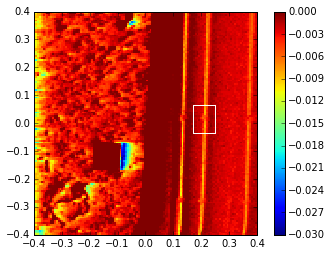

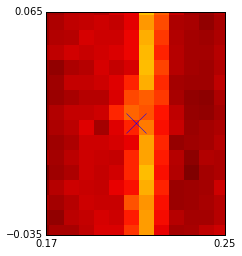

In [18]:
# ---------------------------------------------
# adjust the color scale
clim_min, clim_max = -0.03, 0
# ---------------------------------------------

# ---------------------------------------------
# set region of interest


roi = {
        "xo": 0.21, 'yo': 0.015,
        "dx": 0.08, 'dy': 0.1,
        'xPts': 80, 'yPts': 120
    }
# ---------------------------------------------



fig_overwiew =show_image_all(image_data, roi_initial, roi)


# first measurement of RoI for reference of tracking

In [19]:
# =============================================
# =============================================
# once we are happy with the RoI we start the tracking, first however save the image and the metadata
# =============================================
start_time = strftime("%Y-%m-%d_%H-%M-%S", localtime())

filename = '{:s}_{:s}'.format(start_time,tag)

fig_overwiew.savefig('{:s}/{:s}_Overview.png'.format(dirpath, filename))

with open('{:s}/{:s}_Overview.roi'.format(dirpath, filename), 'w') as outfile:
     json.dump(roi_initial, outfile, sort_keys = True, indent = 4, ensure_ascii=False)
        

In [20]:

# =============================================
# =============================================
# take a first image of the RoI
# =============================================

roi_image_data = take_image(roi)

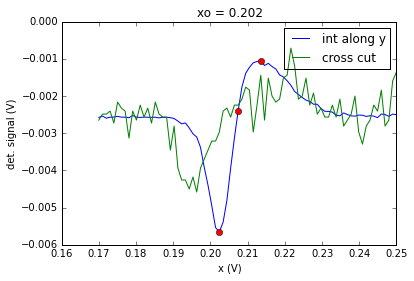

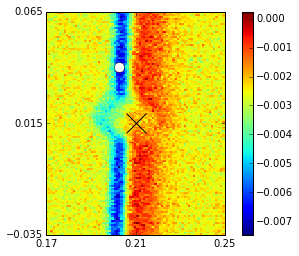

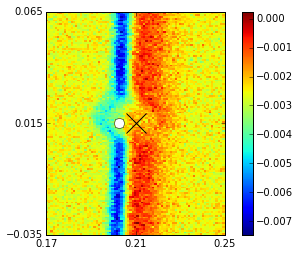

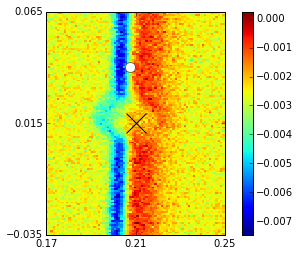

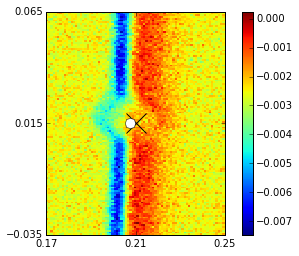

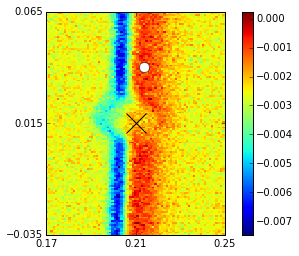

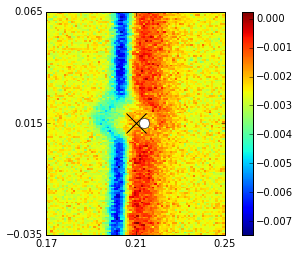

In [21]:
# ---------------------------------------------
# show image

special_pos = find_special_x_pos_in_roi()

x_offsets = special_pos['x_signal_min'] - roi['xo'], special_pos['x_signal_0'] - roi['xo'], special_pos['x_signal_max'] - roi['xo']
y_offsets = [0.025, 0.0]

for x_offset in x_offsets:
    for y_offset in y_offsets:
# fig = plt.figure(figsize=(20,10))
        fig_roi = plot_roi_and_set_laser(roi, roi_image_data, {"x_laser": roi['xo']+x_offset, 'y_laser':  roi['yo']+y_offset})




In [22]:
fo = 1940e3
df = 10e3

freqEnd = fo + df/2.
freqStart = fo - df/2.
freq_df = 2

interval_sampleNum = 1e3

print  fo, freqStart, freqEnd

print 'runs: {:0.0f}'.format( df / (interval_sampleNum *  freq_df) * len(x_offsets) * len(y_offsets))

1940000.0 1935000.0 1945000.0
runs: 30


#  loop breaking up the full scan range into shorter intervals, after each interval correct for drifts

In [23]:
# ======================================================================
# set frequency range of full scan =====================================
# ======================================================================



zi_parameter = {
    'amplitude' : 2.0,
    'offset' : 3.0,
    'freq' : 1e5,
    'ACCoupling' : 0, 
    'inChannel' : 0,
    'outChannel' : 0,
    'auxChannel': 0,
    'add' : 1,
    'range' : 10
}

measure_mechanical_resonance(roi, roi_image_data, x_offsets, y_offsets, filename)

autoConnect connected to a server on port 8005 using API level 1.
autoDetect selected the device dev35 for the measurement.
[['/dev35/sigins/0/imp50', 1], ['/dev35/sigins/0/ac', 0], ['/dev35/sigins/0/range', 4.0], ['/dev35/demods/0/order', 4], ['/dev35/demods/0/rate', 10000.0], ['/dev35/demods/0/harmonic', 1], ['/dev35/demods/0/phaseshift', 0], ['/dev35/sigouts/0/on', 1], ['/dev35/sigouts/0/range', 10], ['/dev35/sigouts/0/enables/6', 1], ['/dev35/sigouts/0/amplitudes/6', 0.2], ['/dev35/AUXOUTS/0/OFFSET', 3.0], ['/dev35/oscs/0/freq', 100000.0], ['/dev35/demods/0/oscselect', 0], ['/dev35/demods/0/adcselect', 0], ['/dev35/sigins/0/diff', 0], ['/dev35/sigouts/0/add', 1]]
2015-06-05 12:36:08	 sweeping	 1935.000 - 1936.998kHz
counter 0, -0.008 0.025
Will perform 1 sweeps....

sample contains 1 sweeps
	 current laser position:	  0.202	 0.202
2015-06-05 12:50:34	 sweeping	 1935.000 - 1936.998kHz
counter 1, -0.008 0.000
Will perform 1 sweeps....

sample contains 1 sweeps
	 current laser positio

In [13]:
len(x_offsets) * len(y_offsets) *  (freqEnd - freqStart) / (freq_df * interval_sampleNum)

120.0